In [ ]:
pip install keras-tcn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.3 MB/s eta 0:00:00


In [ ]:
#LIBREIAS GEOPANDAS, NUMPY
import xarray as xr
import numpy as np, pandas as pd, geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import hvplot.pandas
get_ipython().run_line_magic('matplotlib', 'inline')
import shapely.vectorized
import seaborn as sns
from datetime import datetime
import torch
import torch.nn as nn
from datetime import datetime

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

# Manipulación y tratamiento de Datos
import numpy as np
import geopandas as gpd # conda install --channel conda-forge geopandas

# Visualización de datos
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Modelación Arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Métrica de Evaluación
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics

#Instalar librerias para generar modelos de aprendizaje con Pytorch
import torch
from torch import nn
import torch.nn.functional as F

# No presentar advertencias
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, LSTM, Input, GRU
from tensorflow.keras import backend as K
from tcn import TCN
from collections import defaultdict
import matplotlib.ticker as ticker
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import datetime
import random
import math

cpu is available.


In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


(4.475, 7.27499999999999)

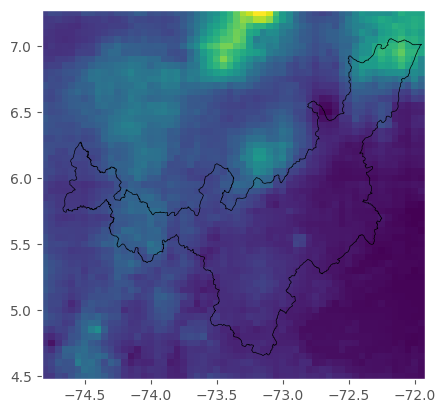

In [ ]:
#CARGAR EL DATASET
#-------------------------------------------------------------------------------------
x = np.arange(-74.8, -71.9, 0.05)
y = np.arange(4.5, 7.3, 0.05)
xx, yy = np.meshgrid(x, y)
xnorm = (xx - xx.min()) / (xx.max() - xx.min())
ynorm = (yy - yy.min()) / (yy.max() - yy.min())

# CARGAR DATASET DE CHIRPS
chirps = xr.open_dataset('/gdrive/My Drive/Rainfall/proyecto/chirps-v2.0.monthly.nc')

#SELECCIONAR LA VARIABLE DE PRECIPITACION
pr = chirps['precip']

# sSELECCIONAR LIMITES (xmin, xmax, ymin and ymax) -- TIEMPO Y PERIODO DE INTERES
pr_boyaca = pr.sel(longitude=slice(-74.8,-71.9), latitude=slice(4.5,7.3),time=slice('2020-01-01','2020-01-01')) #time=slice('1981','2020'))
v = pr_boyaca.to_numpy()

# CONVERTIR DE XARRAY A GEOPANDAS
#-----------------------------------------------------------------------------
df_boyaca = pr_boyaca.to_dataframe().reset_index()
gdf_precip = gpd.GeoDataFrame(df_boyaca.precip, geometry=gpd.points_from_xy(df_boyaca.longitude,df_boyaca.latitude))
gdf_boyaca = gpd.read_file('/gdrive/My Drive/Rainfall/proyecto/MGN_Departamento.shp') #crs="epsg:4326"


v = np.squeeze(v) #np 3-D A 2-D

#DELIMITAR EL DEPARTAMENTO DE BOYACA EN COLOR NEGRO
#-----------------------------------------------------------------------------
fig, ax = plt.subplots()
ax.pcolormesh(xx, yy, v)
xlim, ylim = ax.get_xlim(), ax.get_ylim()
gdf_boyaca.plot(ax=ax, color='none', edgecolor='k')
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

(4.475, 7.27499999999999)

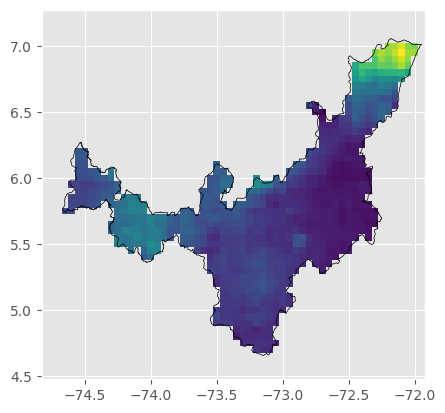

In [ ]:
#DELIMITAR EL DEPARTAMENTO DE BOYACA EN COLOR NEGRO Y QUITAR EXCEDENTE DE MAPA
#------------------------------------------------------------------------------------------
mask = shapely.vectorized.contains(gdf_boyaca.dissolve().geometry.item(), xx, yy)

fig, ax = plt.subplots()
ax.pcolormesh(xx, yy, np.where(mask, v, np.nan))
xlim, ylim = ax.get_xlim(), ax.get_ylim()
gdf_boyaca.plot(ax=ax, color='none', edgecolor='k')
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

In [ ]:
#CARGAR DATASET CON TODAS LA INFORMACION DESDE 1981 HASTA EL 2023.
#--------------------------------------------------------------------------------------------------------
pr_boyaca_all = pr.sel(longitude=slice(-74.8,-71.9), latitude=slice(4.5,7.3),time=slice('1981-01-01','2023-03-01')) #time=slice('1981','2020'))
pr_boyaca_all_mini = pr.sel(longitude=slice(-74.8,-74.6), latitude=slice(4.5,4.7),time=slice('1981-01-01','2023-03-01')) #time=slice('1981','2020'))
# convert xarray to geopandas
df_all = pr_boyaca_all_mini.to_dataframe().reset_index()

In [ ]:
df=df_all.copy()
df

,time,latitude,longitude,precip
0,1981-01-01,4.524998,-74.775002,59.656879
1,1981-01-01,4.524998,-74.725006,55.540077
2,1981-01-01,4.524998,-74.675003,51.964622
3,1981-01-01,4.524998,-74.625008,60.566013
4,1981-01-01,4.574997,-74.775002,59.756550
...,...,...,...,...
8107,2023-03-01,4.625000,-74.625008,225.511078
8108,2023-03-01,4.674999,-74.775002,199.983551
8109,2023-03-01,4.674999,-74.725006,198.153717
8110,2023-03-01,4.674999,-74.675003,205.510254


In [ ]:
# Variables de estacionalidad
df['Year'] = df['time'].apply(lambda x: x.year)
df['Mes'] = df['time'].apply(lambda x: x.month)
df.head()

,time,latitude,longitude,precip,Year,Mes
0,1981-01-01,4.524998,-74.775002,59.656879,1981,1
1,1981-01-01,4.524998,-74.725006,55.540077,1981,1
2,1981-01-01,4.524998,-74.675003,51.964622,1981,1
3,1981-01-01,4.524998,-74.625008,60.566013,1981,1
4,1981-01-01,4.574997,-74.775002,59.756550,1981,1


In [ ]:
# Agregar un año de datos retrasados
df['L1'] = df["precip"].shift(1)
df['L2'] = df["precip"].shift(2)
df['L3'] = df["precip"].shift(3)
df['L4'] = df["precip"].shift(4)
df['L5'] = df["precip"].shift(5)
df['L6'] = df["precip"].shift(6)
df['L7'] = df["precip"].shift(7)
df['L8'] = df["precip"].shift(8)
df['L9'] = df["precip"].shift(9)
df['L10'] = df["precip"].shift(10)
df['L11'] = df["precip"].shift(11)
df['L12'] = df["precip"].shift(12)


In [ ]:
df.head(25)

,time,latitude,longitude,precip,Year,Mes,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12
0,1981-01-01,4.524998,-74.775002,59.656879,1981,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1981-01-01,4.524998,-74.725006,55.540077,1981,1,59.656879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1981-01-01,4.524998,-74.675003,51.964622,1981,1,55.540077,59.656879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1981-01-01,4.524998,-74.625008,60.566013,1981,1,51.964622,55.540077,59.656879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1981-01-01,4.574997,-74.775002,59.756550,1981,1,60.566013,51.964622,55.540077,59.656879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1981-01-01,4.574997,-74.725006,58.118248,1981,1,59.756550,60.566013,51.964622,55.540077,59.656879,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1981-01-01,4.574997,-74.675003,50.752159,1981,1,58.118248,59.756550,60.566013,51.964622,55.540077,59.656879,NaN,NaN,NaN,NaN,NaN,NaN
7,1981-01-01,4.574997,-74.625008,66.479088,1981,1,50.752159,58.118248,59.756550,60.566013,51.964622,55.540077,59.656879,NaN,NaN,NaN,NaN,NaN
8,1981-01-01,4.625000,-74.775002,58.365467,1981,1,66.479088,50.752159,58.118248,59.756550,60.566013,51.964622,55.540077,59.656879,NaN,NaN,NaN,NaN
9,1981-01-01,4.625000,-74.725006,56.381413,1981,1,58.365467,66.479088,50.752159,58.118248,59.756550,60.566013,51.964622,55.540077,59.656879,NaN,NaN,NaN


In [ ]:
df = df.dropna()
df.head(5)

,time,latitude,longitude,precip,Year,Mes,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12
12,1981-01-01,4.674999,-74.775002,55.456490,1981,1,75.268234,57.225189,56.381413,58.365467,66.479088,50.752159,58.118248,59.756550,60.566013,51.964622,55.540077,59.656879
13,1981-01-01,4.674999,-74.725006,52.721329,1981,1,55.456490,75.268234,57.225189,56.381413,58.365467,66.479088,50.752159,58.118248,59.756550,60.566013,51.964622,55.540077
14,1981-01-01,4.674999,-74.675003,59.753742,1981,1,52.721329,55.456490,75.268234,57.225189,56.381413,58.365467,66.479088,50.752159,58.118248,59.756550,60.566013,51.964622
15,1981-01-01,4.674999,-74.625008,77.223648,1981,1,59.753742,52.721329,55.456490,75.268234,57.225189,56.381413,58.365467,66.479088,50.752159,58.118248,59.756550,60.566013
16,1981-02-01,4.524998,-74.775002,119.826553,1981,2,77.223648,59.753742,52.721329,55.456490,75.268234,57.225189,56.381413,58.365467,66.479088,50.752159,58.118248,59.756550


In [ ]:
## pasar la columna "time" a formato datetime
df['datetime'] = pd.to_datetime(
    df['time'],
    format = '%d.%m.%Y %H:%M:%S'
)

## fijar el indice la variable datetime
df = df.set_index('datetime')

## organizar cronologicamente de forma ascendente
df.sort_index(inplace=True)

## finalmente eliminar colimna "time"
df = df.drop(columns=['time'])
df

,latitude,longitude,precip,Year,Mes,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12
datetime,,,,,,,,,,,,,,,,,
1981-01-01,4.674999,-74.775002,55.456490,1981,1,75.268234,57.225189,56.381413,58.365467,66.479088,50.752159,58.118248,59.756550,60.566013,51.964622,55.540077,59.656879
1981-01-01,4.674999,-74.725006,52.721329,1981,1,55.456490,75.268234,57.225189,56.381413,58.365467,66.479088,50.752159,58.118248,59.756550,60.566013,51.964622,55.540077
1981-01-01,4.674999,-74.675003,59.753742,1981,1,52.721329,55.456490,75.268234,57.225189,56.381413,58.365467,66.479088,50.752159,58.118248,59.756550,60.566013,51.964622
1981-01-01,4.674999,-74.625008,77.223648,1981,1,59.753742,52.721329,55.456490,75.268234,57.225189,56.381413,58.365467,66.479088,50.752159,58.118248,59.756550,60.566013
1981-02-01,4.524998,-74.775002,119.826553,1981,2,77.223648,59.753742,52.721329,55.456490,75.268234,57.225189,56.381413,58.365467,66.479088,50.752159,58.118248,59.756550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01,4.625000,-74.625008,142.404861,2023,1,147.462860,136.556610,146.110657,133.975830,144.938354,144.707474,149.763840,129.638153,139.064087,134.261154,138.892563,86.857697
2023-01-01,4.674999,-74.775002,131.197968,2023,1,142.404861,147.462860,136.556610,146.110657,133.975830,144.938354,144.707474,149.763840,129.638153,139.064087,134.261154,138.892563
2023-01-01,4.674999,-74.725006,120.535217,2023,1,131.197968,142.404861,147.462860,136.556610,146.110657,133.975830,144.938354,144.707474,149.763840,129.638153,139.064087,134.261154


In [ ]:
# escala para columna precipitacion
ss = StandardScaler()
df["Normalizedprecip"]=ss.fit_transform(df["precip"].values.reshape(-1,1))
df_scaled = df.drop(["precip"],axis=1)

In [ ]:
df_scaled

,latitude,longitude,Normalizedprecip
datetime,,,
1981-01-01,4.524998,-74.775002,-0.874253
1981-01-01,4.524998,-74.725006,-0.938964
1981-01-01,4.524998,-74.675003,-0.995165
1981-01-01,4.524998,-74.625008,-0.859963
1981-01-01,4.574997,-74.775002,-0.872686
...,...,...,...
2023-01-01,4.625000,-74.625008,0.426434
2023-01-01,4.674999,-74.775002,0.250277
2023-01-01,4.674999,-74.725006,0.082673


In [ ]:
# dividir en variables rezagadas (características) y datos de series de tiempo originales (objetivo)
X2= df.iloc[:,3:] # dividir todas las filas y comenzar con la columna 0 y subir hasta la última columna, pero sin incluirla
y2 = df.iloc[:,2] # dividir todas las filas y la última columna, esencialmente separando la columna 't'

In [ ]:
Y2 = y2
traintarget_size = int(len(Y2) * 0.80)   # Set split
train_target, test_target = Y2[0:traintarget_size], Y2[traintarget_size:len(Y2)]

print('Observaciones para el objetivo: %d' % (len(Y2)))
print('Observaciones de entrenamiento para el objetivo: %d' % (len(train_target)))
print('Observaciones de prueba para el objetivo: %d' % (len(test_target)))

Observaciones para el objetivo: 8068
Observaciones de entrenamiento para el objetivo: 6454
Observaciones de prueba para el objetivo: 1614


In [ ]:
# Features Train-Test split

trainfeature_size = int(len(X2) * 0.80)
train_feature, test_feature = X2[0:trainfeature_size], X2[trainfeature_size:len(X2)]
print('Observaciones para la característica: %d' % (len(X2)))
print('Observaciones de entrenamiento para la característica: %d' % (len(train_feature)))
print('Observaciones de prueba para la característica: %d' % (len(test_feature)))

Observaciones para la característica: 8068
Observaciones de entrenamiento para la característica: 6454
Observaciones de prueba para la característica: 1614


In [ ]:
# Creando Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2,  shuffle=False)

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

# Creamos el modelo con 500 árboles
rfr = RandomForestRegressor(n_estimators=500)

# Entrenamos el modelo
rfr.fit(train_feature, train_target)

# Hacemos las predicciones
fcst = rfr.predict(test_feature)

In [ ]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
evaluacion_metrica(test_target,fcst)

Evaluation metric results:-
MSE is : 550.8780303646429
MAE is : 12.08739341058223
RMSE is : 23.4707910042385
MAPE is : 11.276347365126021
R2 is : 0.8717022143892497



In [ ]:
m=2
i=205
resultado=[]
for m in range(i):
    if m<=1:
        pass
    else:
        RF = RandomForestRegressor(n_estimators=m,n_jobs=-1,random_state=123456789)
        #MODELO ENTRENAMIENTO
        model_RFR = rfr.fit(train_feature, train_target)
        #PREDICCION
        fcst= model_RFR.predict(test_feature)
        resultado.append(np.sqrt(metrics.mean_squared_error(test_target,fcst)))

In [ ]:
print (min(resultado))
contador= 0
for j in (range(len (resultado))):
    if resultado[j]==min(resultado):
        y=contador
        break
    else:
        contador= contador+1

22.88118494724745


In [ ]:
fig = px.line(resultado,template = "plotly_dark",
              title="RMSE de 0 a 205 arboles")
fig.show()

Text(0, 0.5, 'RMSE')

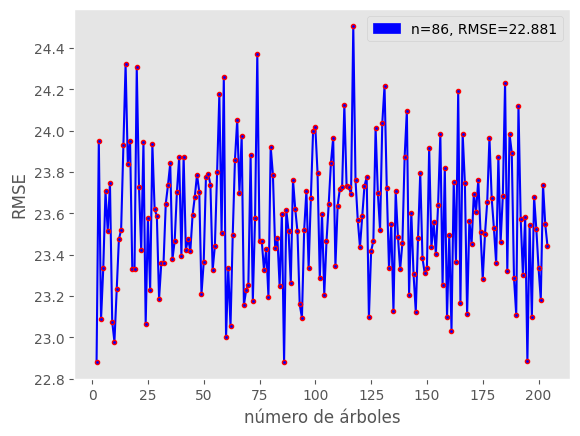

In [ ]:
import matplotlib.patches as mpatches
import sklearn as sk
x= list(range(2,i))
b="{:.3f}".format(min(resultado))
a= mpatches.Patch(color="b",label="n="+str(y+2)+", RMSE="+str(b))
plt.plot (x,resultado,ls="-",color="blue",marker=".",mec="r")
plt.legend(handles=[a])
plt.grid()
plt.xlabel("número de árboles")
plt.ylabel("RMSE")

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

# Creamos el modelo con 500 árboles
rfr_2 = RandomForestRegressor(n_estimators=500)

# Entrenamos el modelo
rfr_2.fit(train_feature, train_target)

# Hacemos las predicciones
fcst_2 = rfr_2.predict(test_feature)

In [ ]:
evaluacion_metrica(test_target,fcst_2)

Evaluation metric results:-
MSE is : 540.5688098870478
MAE is : 12.050431588346632
RMSE is : 23.250135696099665
MAPE is : 11.252428046534114
R2 is : 0.8741031998810345



In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

# Creamos el modelo con 83 árboles
rfr_3 = RandomForestRegressor(n_estimators=83)

# Entrenamos el modelo
rfr_3.fit(train_feature, train_target)

# Hacemos las predicciones
fcst_3 = rfr_3.predict(test_feature)

In [ ]:
evaluacion_metrica(test_target,fcst_3)

Evaluation metric results:-
MSE is : 539.0737775146171
MAE is : 12.074377424364807
RMSE is : 23.217962389378982
MAPE is : 11.258234520586507
R2 is : 0.874451388286138



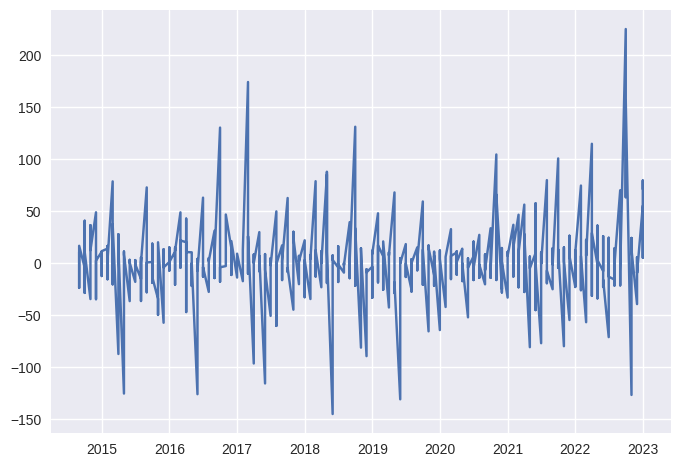

In [ ]:
# Cálculo de errores simples
errores = test_target-fcst_3
plt.plot(errores);